## Discrete Fourier Transform (DFT)
With our newly discretized signals, we'll also have to obtain a discrete version of the Fourier transform as well. There are several concepts to be digested, so let's jump into it.

In [ ]:
# Installing the packages
%pip install ipympl
import numpy as np 
from scipy import signal
import io
from scipy.io import wavfile
from pyodide.http import pyfetch
from matplotlib import pyplot as plt
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
%matplotlib ipympl

# function for reading WAV files from a URL. Must be a RAW link, not GitHub HTML
vocal_sample = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/vocal_sample.wav"

async def read_wav_from_url(url):
    response = await pyfetch(url)
    wav_bytes = await response.bytes()  # get raw binary
    fs, data = wavfile.read(io.BytesIO(wav_bytes))

    # convert to float in [-1, 1]
    if np.issubdtype(data.dtype, np.integer):
        max_val = np.iinfo(data.dtype).max
        data = data.astype(np.float32) / max_val
    else:
        data = data.astype(np.float32)  # already float
    
    return data, fs

### Discrete-Time Fourier Transform (DTFT)

Let's recall the Fourier transform analysis equation for continuous-time signals. Instead of writing it in terms of $\omega$ as we did [before](https://randyaliased.github.io/acspjbook/main/fundamental/05_Fourier_Transform.html), we'll express it directly in terms of the frequency $f$ in Hz by substituting $\omega = 2 \pi f$:

$\begin{align} 
	X(f) &=\int_{-\infty}^{\infty}x(t)e^{-j 2 \pi f t}\text{d}t
\end{align}$

Now that we are dealing with discrete-time signals, there are a few modifications to be made to this formula:
1. The continuous-time variable, $t$, is to be replaced with the discretised version, $n T_s$, where $T_s$ is the sampling period for $n = 0, 1, 2, \dots$. 
2. We replace the integral with a summation.

This leads us to the **discrete-time Fourier transform (DTFT)**:

$\begin{align} 
	X(f) &=\sum\limits_{n=-\infty}^{\infty}x(nT_s)e^{-j 2 \pi f n T_s} = \sum\limits_{n=-\infty}^{\infty}x[n]e^{-j 2 \pi f n T_s} = \sum\limits_{n=-\infty}^{\infty}x[n]e^{-j \frac{2 \pi f}{f_s} n}
\end{align}$

In the last equation, we simply substituted $T_s = 1/f_s$, where $f_s$ is the sampling frequency. In some literature, you will find the term $\Omega = (2 \pi f)/(f_s)$ being used, which is simply a normalized angular frequency (sometimes called a digital frequency) which ranges from $0$ to $2 \pi$. Note in these equations that we have also omitted the $dt$ variable. In the discrete-time domain, this corresponds to $T_s$ and hence only contributes to a scalling, but we'll come back to that later. In any case, we have a version of the Fourier transform that can analyze discrete-time signals. It is, however, of limited use in practice since the left-hand-side of the equation is still continuous in terms of frequency, $f$, i.e., we can obtain the Fourier coefficients at any frequency, f. While that may seem advantageous, as we want to be able to process our signals with computers, it will be more convenient to have a discrete form of the spectrum as well, which carries us over into the **discrete Fourier transform (DFT)**.


### Discrete Fourier Transform (DFT)

Let's make a few modifications to the DTFT:
1. Usually when we take a recording of some signal, we have a finite number of samples, $N$. So let's constrain the limits of the summation to go from $0$ to $N-1$.
2. Let's sample the continuous spectrum. In a similar way to how we sampled time, we sample the frequency axis by replacing $f = k \Delta f$, where $\Delta f$ is a constant spacing between frequency values and k is an integer such that $k = 0, 1, 2, … N-1$.

This results in

$\begin{align} 
	X[k \Delta f] &= \sum\limits_{n=0}^{N-1}x[n]e^{-j 2 \pi k \Delta f n T_s} 
\end{align}$

Let's pause for a second and make sure we understand this. If our signal contained $N=1000$ samples and we were to choose $\Delta f = 10$ Hz, then the values of $k = 0, 1, 2, … N-1$ would correspond to the discrete frequencies $\{0, 10, 20, \dots 9990\}$ Hz, and these are the frequencies at which we would obtain the complex values of the Fourier coefficients (the result of the summation). The integer values of $k$ are commonly referred to as **frequency bins**. 

We, however, cannot typically just choose values for $\Delta f$ as they are constrained by the following relationship, i.e., $\Delta f$ is fixed for some given $f_s$ and $N$:

$\begin{equation}
\Delta f \hspace{0.1cm} T_s = \frac{1}{N}  \rightarrow \Delta f  = \frac{f_s}{N}
\end{equation}$

Substitution of this expression into the previous equation finally brings us to the discrete Fourier transform (DFT) analysis equation:
$\begin{align} 
	X[k] &= \sum\limits_{n=0}^{N-1}x[n]e^{-j \frac{2 \pi}{N} k  n} \\
         &= x[0] + x[1]e^{-j \frac{2 \pi k}{N}} + x[1]e^{-j \frac{2 \pi k}{N} 2} + \dots + x[N-1]e^{-j \frac{2 \pi k}{N} (N-1)}
\end{align}$

We have dropped the dependence on $\Delta f$ on the left-hand-side as it is constant (similar to how we dropped $T_s$ for discrete-time signals). For each value of $k = 0, 1, 2, … N-1$ (for each corresponding frequency), we can interpret this equation as a sum of complex exponentials with normalized frequencies $(2 \pi k)/N = (2 \pi k \Delta f)/f_s$, weighted by the values in $x[n]$ (amplitudes of the signal).  This results in a complex number for each frequency from which we can compute the magnitude and phase, and where the square of the magnitude tells use something about how much energy there is in the signal at that particular frequency. (I hope this is all starting to connect with everything we've done so far!).

And of course, we also have the **inverse DFT**, which for $n = 0, 1, 2, … N-1$, is given by (think about how this relates to the [Fourier series](https://randyaliased.github.io/acspjbook/main/fundamental/04_Fourier_Series.html))

$\begin{align} 
	x[n] &= \frac{1}{N}\sum\limits_{k=0}^{N-1}X[k]e^{j \frac{2 \pi}{N} k  n} \hspace{0.4 cm} 
\end{align}$

Let's do a really simple example just to get an idea of how the DFT works.

In [35]:
# Define a simple array of values to represent x[n]
x = np.array([-0.2, 0.4, 0.3, -1.5])
N = len(x) # number of points in x

print("x[n] =", x)
# Lets implement the DFT formula in Python 
X = np.zeros(N, dtype='complex') # Define an array to hold the DFT values (same length as x)

# We can implement the formula using two for loops (inefficient but it helps to illustrate the concept)
for k in range(N):
    print ("k =", k)
    for n in range(N):
        print ("  n =", n," -->  x[n]*exp_term =", x[n],"*", np.exp((-1j*2*np.pi*k*n)/N))
        X[k] += x[n]*np.exp((-1j*2*np.pi*k*n)/N)
        if n == N-1:
            print ("    Summing these components, X[",k,"] =", X[k])


x[n] = [-0.2  0.4  0.3 -1.5]
k = 0
  n = 0  -->  x[n]*exp_term = -0.2 * (1+0j)
  n = 1  -->  x[n]*exp_term = 0.4 * (1+0j)
  n = 2  -->  x[n]*exp_term = 0.3 * (1+0j)
  n = 3  -->  x[n]*exp_term = -1.5 * (1+0j)
    Summing these components, X[ 0 ] = (-1+0j)
k = 1
  n = 0  -->  x[n]*exp_term = -0.2 * (1+0j)
  n = 1  -->  x[n]*exp_term = 0.4 * (6.123233995736766e-17-1j)
  n = 2  -->  x[n]*exp_term = 0.3 * (-1-1.2246467991473532e-16j)
  n = 3  -->  x[n]*exp_term = -1.5 * (-1.8369701987210297e-16+1j)
    Summing these components, X[ 1 ] = (-0.4999999999999997-1.9000000000000001j)
k = 2
  n = 0  -->  x[n]*exp_term = -0.2 * (1+0j)
  n = 1  -->  x[n]*exp_term = 0.4 * (-1-1.2246467991473532e-16j)
  n = 2  -->  x[n]*exp_term = 0.3 * (1+2.4492935982947064e-16j)
  n = 3  -->  x[n]*exp_term = -1.5 * (-1-3.6739403974420594e-16j)
    Summing these components, X[ 2 ] = (1.2+5.755839955992561e-16j)
k = 3
  n = 0  -->  x[n]*exp_term = -0.2 * (1+0j)
  n = 1  -->  x[n]*exp_term = 0.4 * (-1.8369701987210297

### Defining the frequencies

Hopefully this gave an idea of how the DFT analysis equation works. From a discrete-time signal with $N=4$ values, we obtained a corresponding $N=4$ complex values from our DFT for $k = 0, 1, 2, 3$. As mentioned before, this means that we can plot both the magnitude and phase of the signal. However, we need to know what frequency each of these values of $k$ corresponds to. Luckily, we already saw that simply multiplying $k \Delta f$ for $k = 0, 1, 2, \dots N-1$ will convert the frequency bins to frequency in Hz, 
where $\Delta f$ is the spacing between the sampled frequencies and hence is also referred to as the bin spacing or may be thought of as a frequency resolution.

Recall that we could not freely choose $\Delta f$ and it was defined as  $\Delta f = f_{s}/N$. Hence the corresponding frequency array for the DFT is given by

$\begin{equation}
\frac{k f_{s}}{N}, \hspace{0.3cm} k = 0, 1, 2, \dots N-1
\end{equation}$

which corresponds to frequencies from 0 Hz to $(f_{s}-df)$ Hz. 

It's worth a moment to ponder on the equation $\Delta f = f_{s}/N$ as it has profound consequences. Essentially it tells us that once we have chosen $f_s$ (usually dictated by your sound card), and a number of samples to analyse in our signal, $N$, then your frequency resolution, $\Delta f$ is already set. The only way we can increase our frequency resolution is therefore either by reducing the sampling frequency or by including more samples in our signal to analyze (if they exist). These choices do not come without consequences however. When increasing the number of samples, it means that we lose some temporal resolution of the signal (as we will see in [Time-Frequency analysis](https://randyaliased.github.io/acspjbook/main/fundamental/08_Time_Freq_Analysis.html)). And if we alternatively reduce the sampling frequency, although we increase the resolution, we will reduce the maximum frequency up to which we have information and depending on our soundcard, we can run into aliasing artifacts (recall the Nyquist-Shannon sampling theorem from the whistling demo!).

To continue to get a feel for all of this, let's perform the DFT on another simple array of values, define the frequency array, and plot the magnitude spectrum. We can also plot the phase spectrum, but we'll focus on the magnitude spectrum for now (feel free to modify the code to plot the phase of course!). 

Sampling frequency fs = 1000 Hz
DFT values:
k = 0  --> f = 0.0 Hz and X[ 0 ] = (0.4+0j)
k = 1  --> f = 125.0 Hz and X[ 1 ] = (1.0091883092036782+0.8849242404917501j)
k = 2  --> f = 250.0 Hz and X[ 2 ] = (0.49999999999999983-1.1j)
k = 3  --> f = 375.0 Hz and X[ 3 ] = (-2.8091883092036785+2.0849242404917496j)
k = 4  --> f = 500.0 Hz and X[ 4 ] = (0.5999999999999998-1.347111479062088e-16j)
k = 5  --> f = 625.0 Hz and X[ 5 ] = (-2.809188309203675-2.084924240491753j)
k = 6  --> f = 750.0 Hz and X[ 6 ] = (0.49999999999999833+1.100000000000001j)
k = 7  --> f = 875.0 Hz and X[ 7 ] = (1.0091883092036806-0.8849242404917481j)


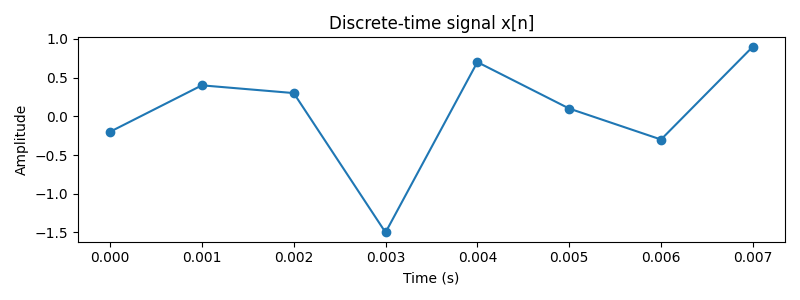

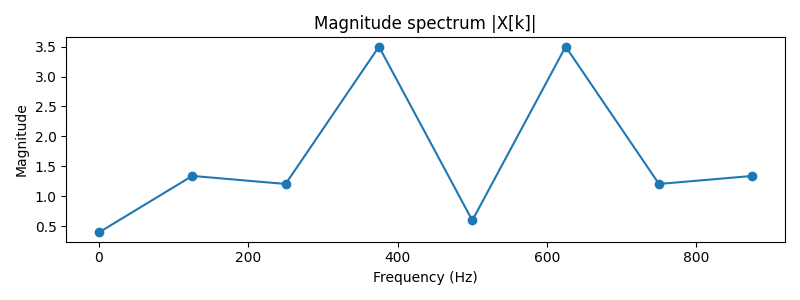

In [63]:
fs = 1000   # let's assume some sampling frequency in Hz

# Define a simple array of values to represent x[n]x
x = np.array([-0.2, 0.4, 0.3, -1.5, 0.7, 0.1, -0.3, 0.9])
t = np.arange(0,len(x),1)*(1/fs) # array of discrete time values (recall T_s = 1/fs and each time step is n.T_s)
N = len(x) # number of points in x

# plot the discrete-time signal
fig, ax = plt.subplots(figsize=(8,3))    
ax.plot(t, x, '-o')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title('Discrete-time signal x[n]')
plt.tight_layout()

# Do the DFT
X = np.zeros(N, dtype='complex') # Define an array to hold the DFT values (same length as x)
# Define the frequency array
delta_f = fs/N # frequency resolution
f = np.arange(0, fs, delta_f) # frequency array 

# We can implement the formula using two for loops (inefficient but it helps to illustrate the concept)
print ("Sampling frequency fs =", fs, "Hz")
print("DFT values:")
for k in range(N):
    for n in range(N):
        X[k] += x[n]*np.exp((-1j*2*np.pi*k*n)/N)
    print ("k =", k, " --> f =", f[k], "Hz and X[",k,"] =", X[k])

# Plot the magnitude spectrum
fig, ax = plt.subplots(figsize=(8,3))    
ax.plot(f, np.abs(X), '-o')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('Magnitude spectrum |X[k]|')
plt.tight_layout()


### The one-sided spectrum

For this arbitrary signal, the magnitude spectrum is not particularly interesting, but it does demonstrate an important outcome from the DFT - there is some sort of repetition or **symmetry**. Recall that we've seen something similar in the Fourier transform, where the spectrum was symmetric around 0 Hz and we had positive and negative frequencies. This is the same thing we're seeing here, except the symmetry occurs around another value. 

We can note some very specific characteristics of this symmetry (see the printed values in the previous code cell to verify):

1. For signals with an even number of samples, the symmetry occurs around the value $k = N/2$ which corresponds to a frequency of $k \Delta f = (N/2).(fs/N) = fs/2$, half of the sampling frequency, and what we referred to as the **Nyquist frequency**. 

2. The symmetry is such that $X[k - N] = X^{*}[k]$ for $k = 1, 2, \dots (\frac{N}{2} -1)$, where $X^{*}[k]$ denotes the complex conjugate of $X[k]$. In words, this means that the complex conjugates the values from $k = 1, 2, \dots (\frac{N}{2} -1)$ are reflected around $k = N/2$. (Again have a look at the printed values above to verify).

3. The values of $X[k]$ for $k=0$ and $k=N/2$ are unique (i.e., not repeated) and real-valued.

This leads us to the concept of the **one-sided spectrum**. Given that there is only unique information up to $k=N/2$, i.e, up to the Nyquist frequency, $f_s/2$, we typically only observe the information of "one side" of the spectrum, i.e., up to this Nyquist frequency. We will formalize this a bit more shortly, but let's start working with a real audio signal and finally do a bit of audio analysis.


### Fast Fourier Transform (FFT)

I have been implementing a very inefficient (and slow) DFT by using two for loops. The fast Fourier transform (FFT) on the other hand, (as the name implies) is a fast algorithm that is [notorious](https://www.youtube.com/watch?v=nmgFG7PUHfo) for implementing a Discrete Fourier Transform (DFT). In Python and many other programming languages, there are [pre-defined packages](https://numpy.org/doc/stable/reference/routines.fft.html) which compute the FFT for us and we'll use that. I'm not going to go into details of the FFT as we've covered the underlying principles of the DFT it's implementing. But if you are interested, have a look at (PUT REF).

Let's perform the FFT on a vocal sample, and plot the one-sided magnitude spectrum. We can plot the phase spectrum, but it may not be particularly interesting. (In case you are curious, [here](https://antieverything.bandcamp.com/track/black-stripe) is where vocal sample stem comes from.) We can see that there is quite a bit of signal energy concentrated below $2$ kHz. 

In [ ]:
# Let's import the vocal sample and plot it (a discrete-time signal x[n])
yy, fs = await read_wav_from_url(vocal_sample) # read in the vocal sample and get its sampling frequency
if len(yy) % 2 != 0: yy = yy[:-1] # remove the last sample to make it even

t = np.arange(0,len(yy),1)*(1/fs) # array of discrete time values
N = len(yy) # number of samples in the signal
print("Sampling frequency fs =", fs, "Hz")
print("Nyquist frequency fs/2 =", fs/2, "Hz")
print("Number of samples N =", N)

IPython.display.display(Audio(yy.T, rate=fs))
      
fig, axes = plt.subplots(2,1) 
axes[0].plot(t, yy)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')

# Let's compute the DFT of the vocal sample and plot the magnitude spectrum
X = np.fft.fft(yy) # compute the DFT using the FFT algorithm  

# Define the frequency array
df = fs/N # frequency resolution
f = np.arange(0,N,1)*df     # frequency array from 0 to fs 

# Plot the magnitude spectrum
axes[1].plot(f, np.abs(X))
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude')
axes[1].set_xlim([0, fs/2])
plt.tight_layout()
plt.show()


UnboundLocalError: local variable '_jsfetch' referenced before assignment

### Power Spectral Density

Put info/eqns/details on psd.

write function here. 

plot the same signal as above.


### Frame-by-frame frequency analysis

Discuss doing a frame by frame analysis.. and show interactive plot. 

In [6]:
# Interactive plot
frame_size=0.3 # Frame size in seconds
hop_size=frame_size/2  # Hop size in seconds
frame_len = int(frame_size * fs) # Frame length in samples
hop_len   = int(hop_size * fs) # Hop length in samples

fig, axes = plt.subplots(2,1)
waveform, = axes[0].plot([], [])
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amp')
axes[0].set_xlim([0, frame_size])
axes[0].set_ylim([-0.6, 0.6])

fftplot, = axes[1].plot([], [], label='original')
fftpeaks, = axes[1].plot([], [], "mx",linewidth=2)
axes[1].set_xlim([0, 8000])
axes[1].set_ylim([-60, 60])

axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('dB/Hz')
# axes[1].legend()



# number of complete frames we can fit
n_frames = 1 + (len(yy) - frame_len) // hop_len

energies = np.zeros(n_frames)
frame_times = np.zeros(n_frames)
zcr = np.zeros(n_frames)


def update(i=0):

    start = i * hop_len
    frame = yy[start:start+frame_len]
    fig.canvas.draw_idle()
    
    YY = np.fft.fft(frame,axis=0)  # make sure to specify the axis. zero in this case since the data is along the first axis.
                            # Since yy was an Nx1 vector, python wants to know just where the "N" values are, i.e. in axis = 0
    #YYss = YY[0:N//2+1]  # Single sided spectrum. The last value will be N/2, since python goes up to N-1 when slicing vectors like this.

    df = fs/frame_len  # the frequency bin spacing
    freqs = np.arange(0,fs,df) # first value = DC, last value = fs/2
    
    t = np.arange(0,frame_len/fs,1/fs)
    # print(start/fs)
    # print(frame_len/fs)
    
    waveform.set_data(t, frame)
    fftplot.set_data(freqs, 10*np.log10(np.abs(YY**2)))

    IPython.display.display(Audio(frame.T, rate=fs,normalize=True))

print('Move the slider to see how the hyperparameters affect performance ')
interact(update, i=(0,n_frames,1));

NameError: name 'fs' is not defined